# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
datagen = ImageDataGenerator(rescale=1./255)
gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [3]:
labels.shape[0]

7591

In [4]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [6]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [7]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


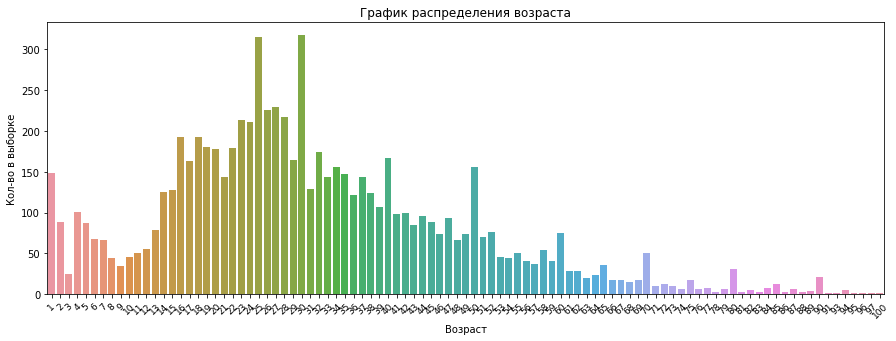

In [12]:
plt.figure(figsize=(15,5))
plt.xticks(rotation=45, fontsize=9)
sns.countplot(data=labels, x='real_age')
plt.title('График распределения возраста')
plt.xlabel('Возраст')
plt.ylabel('Кол-во в выборке');

#####
Возраст: 50


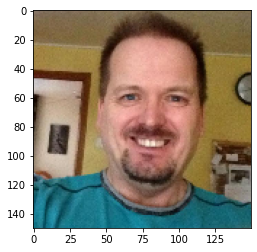

#####
Возраст: 51


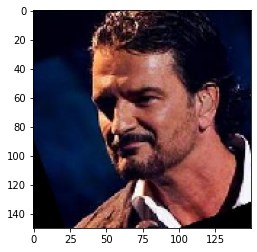

#####
Возраст: 49


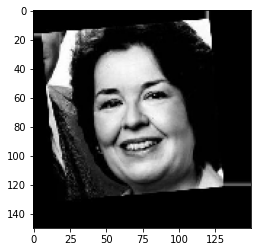

#####
Возраст: 23


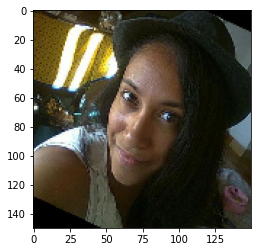

#####
Возраст: 21


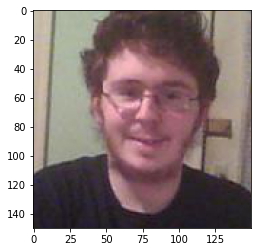

#####
Возраст: 30


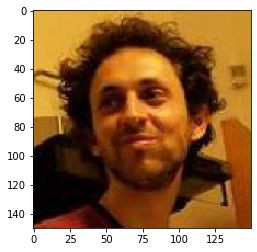

#####
Возраст: 24


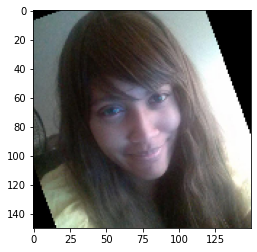

#####
Возраст: 29


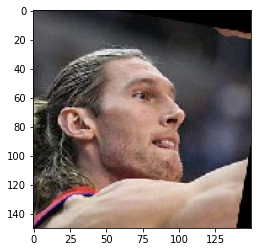

#####
Возраст: 32


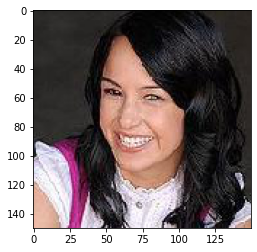

#####
Возраст: 9


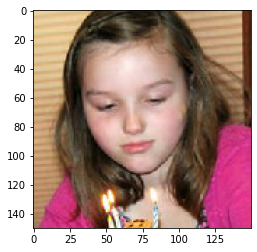

In [5]:
for _ in range(10):
    img, label = gen_flow.next()
    print('#####')
    print('Возраст:',label[0])
    plt.imshow(img[0])
    plt.show()

Размер выборки - 7591 изображений. Соотношение тренировочной и тестовой выборки 75/25%

Датасет состоит из папки с изображениями и сsv-файла содеращего 2 колонки: 

1 - с названием изображения 

2 - с возрастом человека (целевой признак)

Средний возраст выборки - 31.2, медиана - 29 лет. Половина всех возрастов расположена в диапазоне от 20 до 41 года. 

## Обучение модели

```python

from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd

def load_train(path):
    labels = pd.read_csv(path+'/labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255,
                                       horizontal_flip = True,  
                                       rotation_range=90, width_shift_range=0.4, 
                                       height_shift_range=0.4)
    train_gen_flow = train_datagen.flow_from_dataframe(
            dataframe=labels,
            directory=path+'/final_files/',
            x_col='file_name',
            y_col='real_age',
            target_size=(150, 150),
            batch_size=32,
            subset='training',
            class_mode='raw',
            seed=12345)
    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path+'/labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
            dataframe=labels,
            directory=path+'/final_files/',
            x_col='file_name',
            y_col='real_age',
            target_size=(150, 150),
            batch_size=32,
            subset='validation',
            class_mode='raw',
            seed=12345)
    return test_gen_flow

def create_model(input_shape):

    optimizer = Adam(lr=0.0001)

    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mse',
                  metrics=['mae'])
    model.summary()
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=15,
               steps_per_epoch=None, validation_steps=None):

    model.fit(train_data,
              validation_data=test_data,
            batch_size=batch_size,
            steps_per_epoch=steps_per_epoch,
            validation_steps=validation_steps,
            epochs=epochs,
            verbose=2, shuffle=True)
    return model

```

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.

Downloading data from https://github.com/keras-team/keras-applications/releases/download/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5

    8192/94765736 [..............................] - ETA: 5s
  106496/94765736 [..............................] - ETA: 49s
  557056/94765736 [..............................] - ETA: 18s
 2293760/94765736 [..............................] - ETA: 6s 
 7684096/94765736 [=>............................] - ETA: 2s
12722176/94765736 [===>..........................] - ETA: 1s
16965632/94765736 [====>.........................] - ETA: 1s
21192704/94765736 [=====>........................] - ETA: 1s
25436160/94765736 [=======>......................] - ETA: 1s
29679616/94765736 [========>.....................] - ETA: 1s
33914880/94765736 [=========>....................] - ETA: 1s
38158336/94765736 [===========>..................] - ETA: 1s
42393600/94765736 [============>.................] - ETA: 1s
46628864/94765736 [=============>................] - ETA: 1s
50872320/94765736 [===============>..............] - ETA: 0s
55115776/94765736 [================>.............] - ETA: 0s
59367424/94765736 [=================>............] - ETA: 0s
63594496/94765736 [===================>..........] - ETA: 0s
67846144/94765736 [====================>.........] - ETA: 0s
72073216/94765736 [=====================>........] - ETA: 0s
76316672/94765736 [=======================>......] - ETA: 0s
80551936/94765736 [========================>.....] - ETA: 0s
84803584/94765736 [=========================>....] - ETA: 0s
89038848/94765736 [===========================>..] - ETA: 0s
93290496/94765736 [============================>.] - ETA: 0s
94773248/94765736 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
=================================================================
Total params: 23,589,761
Trainable params: 23,536,641
Non-trainable params: 53,120
_________________________________________________________________
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/15
2023-05-24 21:30:29.177062: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-05-24 21:30:31.424088: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 99s - loss: 343.6234 - mae: 13.8152 - val_loss: 437.8546 - val_mae: 15.8528
Epoch 2/15
178/178 - 60s - loss: 152.9427 - mae: 9.3876 - val_loss: 888.8235 - val_mae: 24.9659
Epoch 3/15
178/178 - 60s - loss: 138.7788 - mae: 8.9813 - val_loss: 560.8487 - val_mae: 18.5526
Epoch 4/15
178/178 - 60s - loss: 124.7721 - mae: 8.4880 - val_loss: 206.4937 - val_mae: 10.7008
Epoch 5/15
178/178 - 61s - loss: 118.9044 - mae: 8.2573 - val_loss: 170.8432 - val_mae: 9.7518
Epoch 6/15
178/178 - 61s - loss: 113.1030 - mae: 8.1182 - val_loss: 101.5284 - val_mae: 7.6112
Epoch 7/15
178/178 - 61s - loss: 108.9483 - mae: 7.9927 - val_loss: 105.0688 - val_mae: 7.7924
Epoch 8/15
178/178 - 61s - loss: 99.7088 - mae: 7.6344 - val_loss: 100.6596 - val_mae: 7.7153
Epoch 9/15
178/178 - 61s - loss: 102.7850 - mae: 7.6961 - val_loss: 98.4485 - val_mae: 7.4812
Epoch 10/15
178/178 - 60s - loss: 100.2027 - mae: 7.5936 - val_loss: 106.4402 - val_mae: 7.9542
Epoch 11/15
178/178 - 61s - loss: 86.4975 - mae: 7.1391 - val_loss: 93.9750 - val_mae: 7.3818
Epoch 12/15
178/178 - 60s - loss: 83.0197 - mae: 7.0461 - val_loss: 103.4406 - val_mae: 7.6763
Epoch 13/15
178/178 - 60s - loss: 85.3932 - mae: 7.0618 - val_loss: 189.9171 - val_mae: 11.0377
Epoch 14/15
178/178 - 60s - loss: 77.9986 - mae: 6.7223 - val_loss: 135.5600 - val_mae: 9.2750
Epoch 15/15
178/178 - 60s - loss: 78.3588 - mae: 6.7261 - val_loss: 115.2181 - val_mae: 7.8977
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 115.2181 - mae: 7.8977
Test MAE: 7.8977




```

## Анализ обученной модели

Размер изображения принят 150х150

Размер тестовой выборки 25%

Применены аугментации: отражение по  горизонтали, повороты до 90 градусов, сдвиги изображения по вертикали и горизонтали на 40% от исходного размера

Алгоритм обучения - Adam, learning rate - 0.0001

Архитектура сети - ResNet50, веса: ImageNet

Функция потерь - MSE

Количество эпох - 15

MAE на тестовой выборке: 7.89

В процессе обучения показатель целевой метрики на тренировочных данных постепенно снижается, но на тестовой выборке стабильного снижения нет